<a href="https://colab.research.google.com/github/vanigupta05/E-waste-classification/blob/main/E_Waste.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import kagglehub
import shutil
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

In [ ]:
# Download dataset (default goes to /root/.kagglehub/...)
path = kagglehub.dataset_download("akshat103/e-waste-image-dataset")

# Destination directory (this will be visible in left panel)
dest_path = "/content/e-waste-image-dataset/"

# Remove existing directory if it exists
if os.path.exists(dest_path):
    shutil.rmtree(dest_path)

# Move to desired directory
shutil.copytree(path, dest_path)

print("Dataset available at:", dest_path)

100%|██████████| 11.8M/11.8M [00:00<00:00, 150MB/s]

Extracting files...


Dataset available at: /content/e-waste-image-dataset/


# Importing Dataset

In [ ]:
import os
import pandas as pd

# Paths to each split
dataset_base = "/content/e-waste-image-dataset/modified-dataset"
splits = ['train', 'test', 'val']

# Collect data
data = []

for split in splits:
    split_path = os.path.join(dataset_base, split)
    if not os.path.exists(split_path):
        continue

    for category in os.listdir(split_path):
        category_path = os.path.join(split_path, category)
        if os.path.isdir(category_path):
            num_files = len([
                f for f in os.listdir(category_path)
                if os.path.isfile(os.path.join(category_path, f))
            ])
            data.append({
                "split": split,
                "category": category,
                "num_images": num_files
            })

# Convert to DataFrame
df = pd.DataFrame(data)


# Display
df = df.sort_values(by=["split", "category"]).reset_index(drop=True)


In [ ]:
base_dir = "/content/e-waste-image-dataset/modified-dataset"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")

In [ ]:
img_size = (224, 224)
batch_size = 32

train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    train_dir, image_size=img_size, batch_size=batch_size
)
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir, image_size=img_size, batch_size=batch_size
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir, image_size=img_size, batch_size=batch_size
)

# Save the class names BEFORE prefetch
class_names = train_ds_raw.class_names



Found 2400 files belonging to 10 classes.
Found 300 files belonging to 10 classes.
Found 300 files belonging to 10 classes.


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds_raw.prefetch(AUTOTUNE)
val_ds = val_ds.prefetch(AUTOTUNE)
test_ds = test_ds.prefetch(AUTOTUNE)

In [ ]:
from tensorflow.keras import layers, models

base_model = tf.keras.applications.EfficientNetB0(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)
base_model.trainable = False  # Freeze base

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Dense(128, activation='relu'),
    layers.Dense(len(train_ds_raw.class_names), activation='softmax')
])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_ds, validation_data=val_ds, epochs=10)

Epoch 1/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 44s 226ms/step - accuracy: 0.7311 - loss: 0.9291 - val_accuracy: 0.9633 - val_loss: 0.1367
Epoch 2/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 13s 49ms/step - accuracy: 0.9689 - loss: 0.1094 - val_accuracy: 0.9633 - val_loss: 0.1355
Epoch 3/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.9853 - loss: 0.0556 - val_accuracy: 0.9733 - val_loss: 0.1245
Epoch 4/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.9906 - loss: 0.0378 - val_accuracy: 0.9600 - val_loss: 0.1445
Epoch 5/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - accuracy: 0.9939 - loss: 0.0287 - val_accuracy: 0.9733 - val_loss: 0.1332
Epoch 6/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 39ms/step - accuracy: 0.9972 - loss: 0.0191 - val_accuracy: 0.9633 - val_loss: 0.1502
Epoch 7/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9960 - loss: 0.0198 - val_accuracy: 0.9600 - val_loss: 0.1538
Epoch 8/10
75/75 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - accuracy: 0.9963 - loss: 0.0146 - val_accuracy: 0.9600 

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print("Test accuracy:", test_acc)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9660 - loss: 0.0748
Test accuracy: 0.9800000190734863


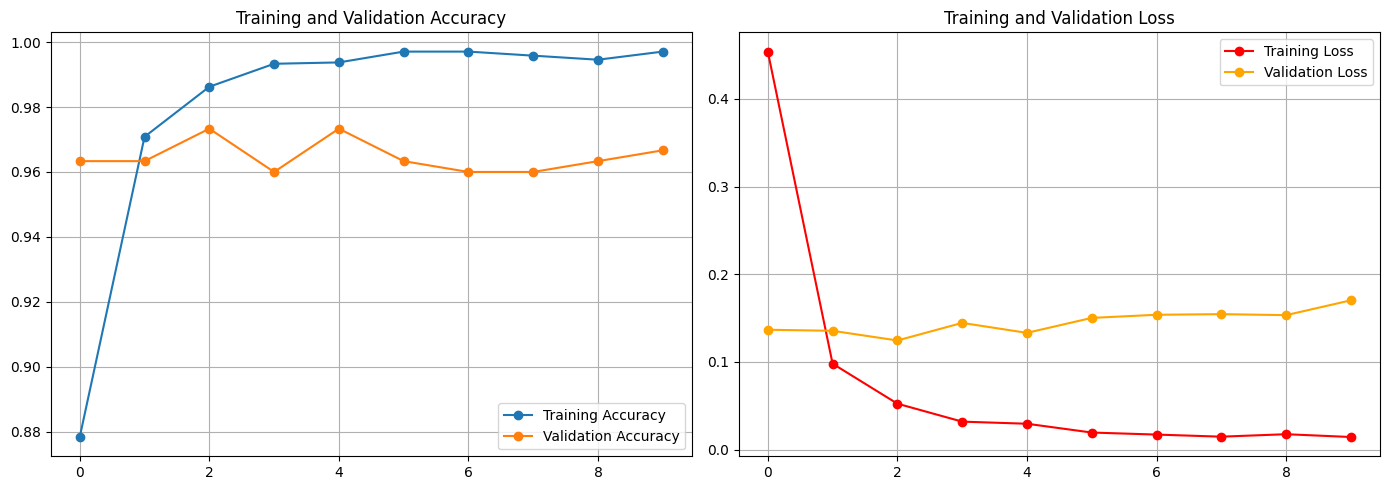

In [ ]:

# Extract accuracy and loss from training history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

# Plot accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy', marker='o')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', marker='o')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss', marker='o', color='red')
plt.plot(epochs_range, val_loss, label='Validation Loss', marker='o', color='orange')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np

class_names = train_ds_raw.class_names

def predict_image(image_path):
    img = tf.keras.utils.load_img(image_path, target_size=img_size)
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)  # Batch dimension

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = np.max(predictions[0])

    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step


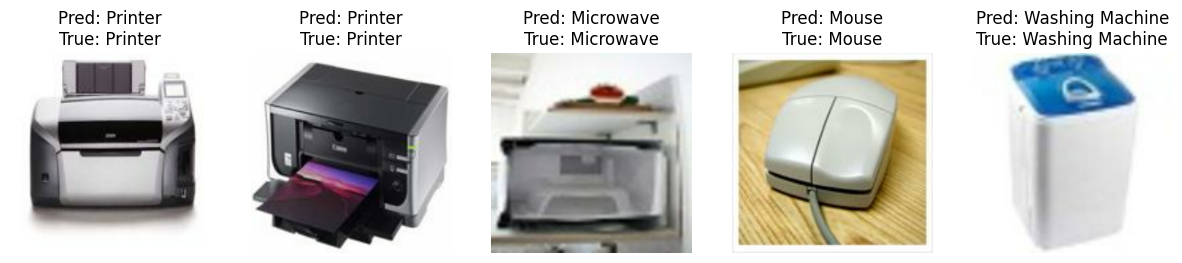

In [ ]:
import matplotlib.pyplot as plt

# Display 5 test images with predicted and true labels
for images, labels in test_ds.take(1):  # take one batch
    preds = model.predict(images)
    pred_classes = np.argmax(preds, axis=1)

    plt.figure(figsize=(15, 6))
    for i in range(5):
        ax = plt.subplot(1, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(f"Pred: {class_names[pred_classes[i]]}\nTrue: {class_names[labels[i]]}")
        plt.axis("off")

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

y_true = []
y_pred = []

# Loop over all test batches
for images, labels in test_ds:
    preds = model.predict(images)
    pred_classes = np.argmax(preds, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(pred_classes)

# Convert to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Calculate accuracy
acc = accuracy_score(y_true, y_pred)
print(f"\n✅ Overall test accuracy: {acc * 100:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step

✅ Overall test accuracy: 98.00%


In [ ]:
!pip install opencv-python

In [ ]:
from IPython.display import Javascript
from google.colab.output import eval_js
from base64 import b64decode
import PIL.Image
import io

def capture_image_from_webcam():
    js_code = '''
        async function captureWebcamImage() {
            const div = document.createElement('div');
            const video = document.createElement('video');
            const button = document.createElement('button');
            button.textContent = 'Capture';
            div.appendChild(video);
            div.appendChild(button);
            document.body.appendChild(div);

            const stream = await navigator.mediaDevices.getUserMedia({ video: true });
            video.srcObject = stream;
            await video.play();

            video.style.width = '400px';

            await new Promise((resolve) => {
                button.onclick = resolve;
            });

            const canvas = document.createElement('canvas');
            canvas.width = video.videoWidth;
            canvas.height = video.videoHeight;
            canvas.getContext('2d').drawImage(video, 0, 0);

            stream.getTracks().forEach(track => track.stop());
            div.remove();

            return canvas.toDataURL('image/jpeg');
        }
    '''
    # Inject JS function
    display(Javascript(js_code))

    # Call the JS function (note: string name only here)
    data = eval_js("captureWebcamImage()")

    # Decode the image
    binary = b64decode(data.split(',')[1])
    img = PIL.Image.open(io.BytesIO(binary))
    return img

<IPython.core.display.Javascript object>

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


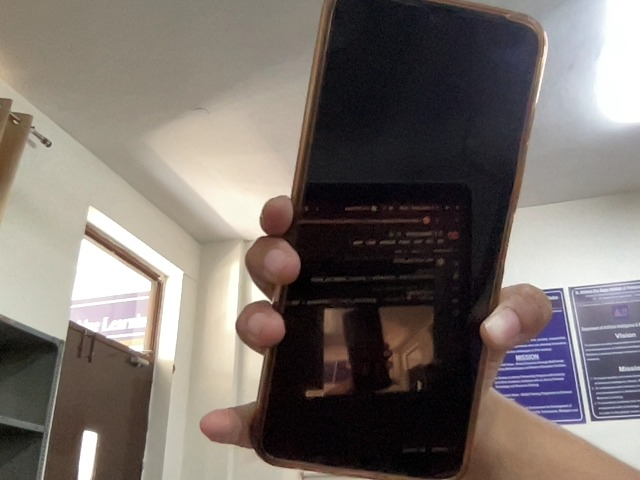


🧠 Prediction: Mobile (99.47% confidence)


In [ ]:
# Capture image
img = capture_image_from_webcam()

# Save it
img_path = "/content/captured_image.jpg"
img.save(img_path)

# Predict
predicted_class, confidence = predict_image(img_path)

# Show image and prediction
display(img)
print(f"\n🧠 Prediction: {predicted_class} ({confidence * 100:.2f}% confidence)")